In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# for the model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import plot_roc_curve, roc_auc_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

# for feature selection 
from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection
)

# for oversampling
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# Azure
from azureml.core import Workspace, Dataset

In [2]:
data = pd.read_csv("Dataset/winequality-red.csv")

In [3]:
df = data.copy()

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
# Transformation of quality values
# from 0 to 6 -> 0 and from 7 and upper -> 1
df['quality'] = np.where(df.quality < 7, 0, 1)

In [8]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.135710
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.342587
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,0.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


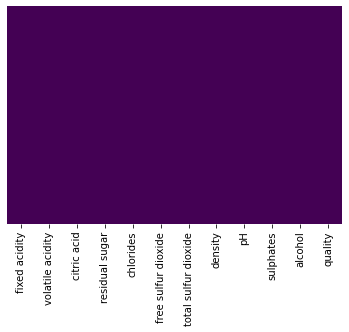

In [9]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

C:\Users\gcarn\anaconda3\envs\Learn_ML\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


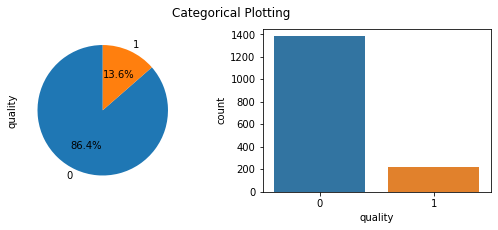

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
df['quality'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axs[0])
sns.countplot(df.quality, data=df, ax=axs[1])
fig.suptitle('Categorical Plotting')
plt.show()

In [11]:
# make a list of the numerical variables first
continues = [var for var in data.columns if data[var].dtype!='O'and var !='quality']

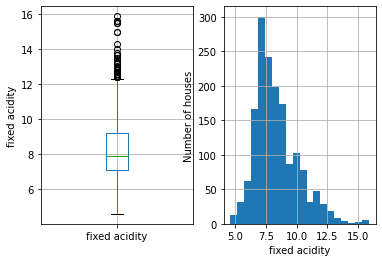

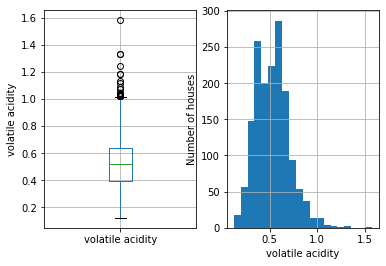

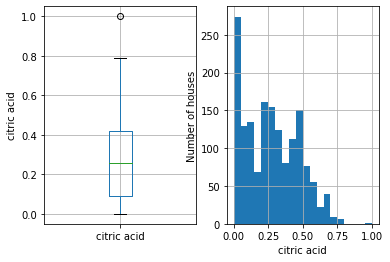

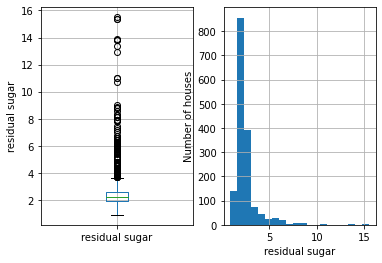

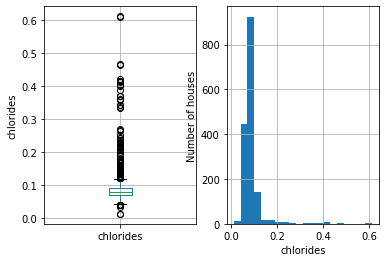

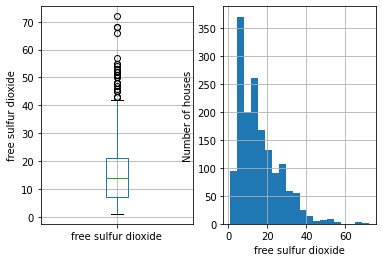

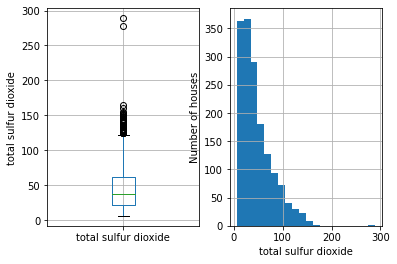

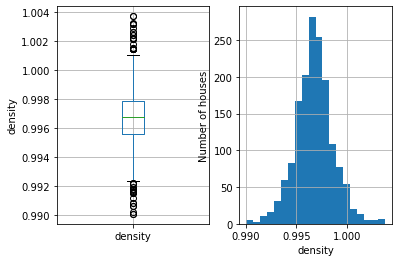

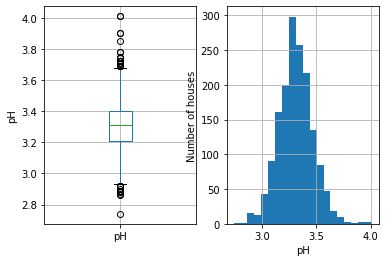

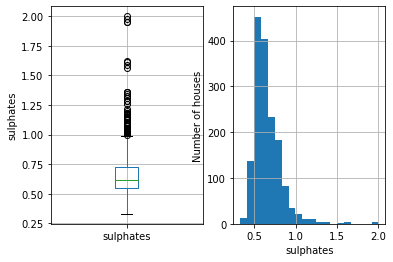

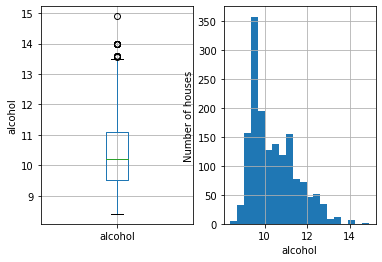

In [12]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continues:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
                                     df.drop('quality', axis=1), 
                                     df.quality, random_state=0
                                   )

In [14]:
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4
)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [15]:
# need ENN  as argument of SMOTEENN
enn = EditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=4)


smenn = SMOTEENN(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    smote=sm,
    enn=enn,
    n_jobs=4
)

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)

In [16]:
y_train.value_counts(), y_smenn.value_counts()

(0    1027
 1     172
 Name: quality, dtype: int64,
 0    1027
 1     952
 Name: quality, dtype: int64)

In [17]:
continues = X_smenn.columns.to_list()

In [18]:
my_pipe = Pipeline([

    # discretisation + encoding
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=continues)),
    
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=continues)),
   
    # feature selection
    ('constant', DropConstantFeatures(tol=0.5)),
    ('duplicated', DropDuplicateFeatures()),
    ('correlation', SmartCorrelatedSelection(selection_method='variance')),
    
     # feature Scaling - section 10
    ('scaler', StandardScaler()),
])

In [19]:
# First create the base model to tune
rf = RandomForestClassifier()

param_grid = dict(
    n_estimators=stats.randint(10, 1000),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    max_features = ('auto', 'sqrt'),
    bootstrap = (True, False)
    )

In [20]:
# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(rf, 
                               param_grid, 
                               n_iter = 60,
                               scoring='roc_auc',
                               cv = 5,
                               random_state=42, 
                               n_jobs = -1, 
                               refit=True)

In [21]:
clf = make_pipeline(my_pipe, rf_random)

In [22]:
clf.fit(X_smenn, y_smenn)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('discretisation',
                                  EqualFrequencyDiscretiser(q=5,
                                                            return_object=True,
                                                            variables=['fixed '
                                                                       'acidity',
                                                                       'volatile '
                                                                       'acidity',
                                                                       'citric '
                                                                       'acid',
                                                                       'residual '
                                                                       'sugar',
                                                                       'chlorides',
                                        

In [23]:
X_train_preds = clf.predict(X_smenn)
X_test_preds = clf.predict(X_test)

In [24]:
print('Train set')
print('roc-auc: {}'.format(roc_auc_score(y_smenn, X_train_preds)))

print('Test set')
print('roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
roc-auc: 0.8439087903905477
Test set
roc-auc: 0.8025039123630674


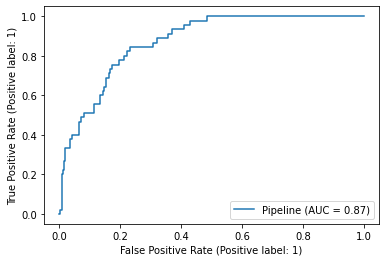

In [25]:
rf_disp = plot_roc_curve(clf, X_test, y_test)

In [26]:
# Save processed dataset 
df.to_csv('Dataset/wine_dataset_processed.csv',index=False)

# Register dataset to the workspace

In [27]:
subscription_id = '5b8e1003-6bb2-4d1e-96ba-246eab1bc9f8'
resource_group = 'Learn_MLOps'
workspace_name = 'MLOps_WS'

In [28]:
workspace = Workspace(subscription_id, resource_group, workspace_name)

In [29]:
# get the datastore to upload prepared data
datastore = workspace.get_default_datastore()

In [30]:
# upload the local file from src_dir to the target_path in datastore
datastore.upload(src_dir='Dataset', target_path='data')

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 2 files
Target already exists. Skipping upload for data\winequality-red.csv
Target already exists. Skipping upload for data\wine_dataset_processed.csv
Uploaded 0 files


$AZUREML_DATAREFERENCE_8ef2b4449875499bbe1f359b40ac0252

In [31]:
dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/wine_dataset_processed.csv'))

In [32]:
# preview the first 3 rows of the dataset from datastore
dataset.take(3).to_pandas_dataframe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0


In [33]:
# Register Dataset to workspace
wine_ds = dataset.register(workspace=workspace,
                                 name='processed_wine_data',
                                 description='processed wine data')